# Pre Set E ML dataset analysis



In [1]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#####################################################################
#                     MultiLabel Analysis                           #
#####################################################################
# In this notebook, we will analyze the multi-label information in  #
# this new dataset.                                                 #
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

'\n#####################################################################\n#                     MultiLabel Analysis                           #\n#####################################################################\n# In this notebook, we will analyze the multi-label information in  #\n# this new dataset.                                                 #\n'

We will need some libraries for our multi label experiments

In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
pd.set_option('max_colwidth',400)
from preprocess import Preproccesor
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, average_precision_score, hamming_loss, precision_recall_curve


import time
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
X, yt, y = Preproccesor.load_multi_label_data(True) #yt has continuous data, y has binary
label_names = ["violence","directed_vs_generalized","gender","race","national_origin","disability","religion","sexual_orientation"]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnmollas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnmollas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.DataFrame(y,columns=label_names)

In [4]:
table = {"gender":[0,0,0,0],"race":[0,0,0,0],"national_origin":[0,0,0,0],"disability":[0,0,0,0],"religion":[0,0,0,0],"sexual_orientation":[0,0,0,0]}
for i in y:
    j = -1
    if i[0] == 1 and i[1] == 1:
        j = 0
    elif i[0] == 0 and i[1] == 1:
        j = 1
    elif i[0] == 1 and i[1] == 0:
        j = 2
    elif i[0] == 0 and i[1] == 0:
        j = 3
    table["gender"][j] = table["gender"][j] + i[2]
    table["race"][j] = table["race"][j] + i[3]
    table["national_origin"][j] = table["national_origin"][j] + i[4]
    table["disability"][j] = table["disability"][j] + i[5]
    table["religion"][j] = table["religion"][j] + i[6]
    table["sexual_orientation"][j] = table["sexual_orientation"][j] + i[7]

In [5]:
list(table.values())

[[14, 22, 13, 37],
 [4, 13, 12, 47],
 [5, 11, 18, 40],
 [12, 15, 8, 18],
 [11, 8, 24, 38],
 [11, 15, 11, 36]]

Now lets compute the **density** and the **cardinality** of the dataset, as well as the local cardinality and density (for each label).




In [6]:
categories = list(yt)
counts = []
for i in range(0,len(y[0])):
    counts.append((label_names[i], sum(y[:,i]), sum(yt[:,i]), sum(y[:,i])/len(y),sum(yt[:,i])/len(yt), (sum(y[:,i])/len(y[0]))/len(y),(sum(yt[:,i])/len(yt[0]))/len(yt))) #Sum is okay because y it countains 0 and 1s so it will count the labels that exist
df_stats = pd.DataFrame(counts, columns = ['category', 'number_of_comments', 'number_of_comments_cont', 'local_cardinality', 'local_cardinality_cont', 'local_density', 'local_density_cont'])
print("Dataset Total Cardinality:",sum(df_stats['local_cardinality'].values),", Cont:",sum(df_stats['local_cardinality_cont'].values))
print("Dataset Total Desnity:",sum(df_stats['local_density'].values),", Cont:",sum(df_stats['local_density_cont'].values))
df_stats

Dataset Total Cardinality: 1.6628175519630484 , Cont: 1.6423591467829104
Dataset Total Desnity: 0.20785219399538105 , Cont: 0.2052948933478638


,category,number_of_comments,number_of_comments_cont,local_cardinality,local_cardinality_cont,local_density,local_density_cont
0,violence,142,142.287849,0.327945,0.328609,0.040993,0.041076
1,directed_vs_generalized,135,130.423116,0.311778,0.301208,0.038972,0.037651
2,gender,86,96.002304,0.198614,0.221714,0.024827,0.027714
3,race,76,76.592069,0.175520,0.176887,0.021940,0.022111
4,national_origin,74,75.152546,0.170901,0.173562,0.021363,0.021695
5,disability,53,51.194048,0.122402,0.118231,0.015300,0.014779
6,religion,81,73.715160,0.187067,0.170243,0.023383,0.021280
7,sexual_orientation,73,65.774418,0.168591,0.151904,0.021074,0.018988


Text(0.5, 0, 'category')

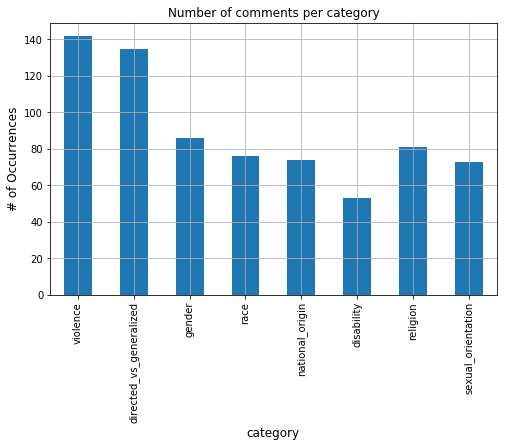

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)